### Introduction
In this exercise you will build three (optionally four) different networks to experiment with one of the applications of recurrent neural networks called Machine Translation. The preprocessing pipeline that prepares the input data for feeding into the neural network models is provided to you. Therefore, in this excercise you focus on building and experimenting with different network architectures. 

Optional: To learn more about recurrent neural networks (such as RNN, GRU, and LSTM) their architectures, the differences between them and their applications you can watch this free tutorial: [Sequences and Recurrent networks Tutorial](https://www.youtube.com/watch?v=87kLfzmYBy8&ab_channel=DeepMind)

In [ ]:
# You may want to upgrade the tensorflow package to the latest verion (currently version 2.3) if you have the proper infrastructure
# !pip install --upgrade tensorflow

### Setup


In [ ]:
# To get access to a GPU instance you can use the `change runtime type` and set the option to `GPU` from the `Runtime` tab  in the notebook
# Checking the GPU availability for the notebook
import tensorflow
tensorflow.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# import collection
import io
import pandas as pd
import numpy as np
from typing import List 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

### Loading and Preprocessing the Data

#### Reading CSV data files as a list of strings, where each string represents a single line from the text


In [ ]:
import csv
from io import TextIOWrapper
from zipfile import ZipFile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with ZipFile('/content/drive/MyDrive/Colab Notebooks/LSTM/small_vocab_en.csv.zip') as zf:
    with zf.open('small_vocab_en.csv', 'r') as infile:
        reader = csv.reader(TextIOWrapper(infile, 'utf-8'), delimiter='\n' )
        english_text = [item for sublist in reader for item in sublist]
        print(f"English text samples: {english_text[0:2]}")

English text samples: ['new jersey is sometimes quiet during autumn , and it is snowy in april .', 'the united states is usually chilly during july , and it is usually freezing in november .']


In [ ]:
with ZipFile('/content/drive/MyDrive/Colab Notebooks/LSTM/small_vocab_fr.csv.zip') as zf:
    with zf.open('small_vocab_fr.csv', 'r') as infile:
        reader = csv.reader(TextIOWrapper(infile, 'utf-8'), delimiter='\n' )
        french_text = [item for sublist in reader for item in sublist]
        print(f"French translation text samples: {french_text[0:2]}")


French translation text samples: ["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .", 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .']


In [ ]:
# TODO: Data exploration -> calculate and print some statistics on data
# Anzahl an samples
print(len(french_text))
print(len(english_text))

137860
137860


In [ ]:
# Anzahl an einmaligen samples
print(len(set(french_text)))
print(len(set(english_text)))

120806
129174


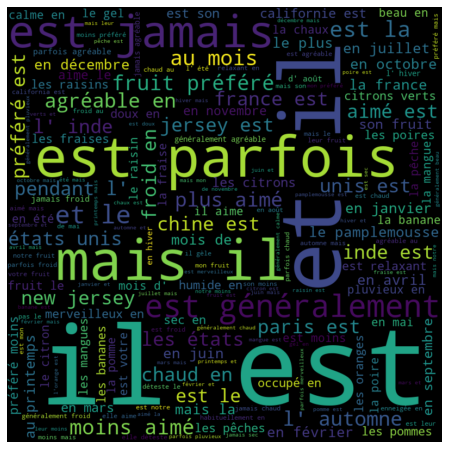

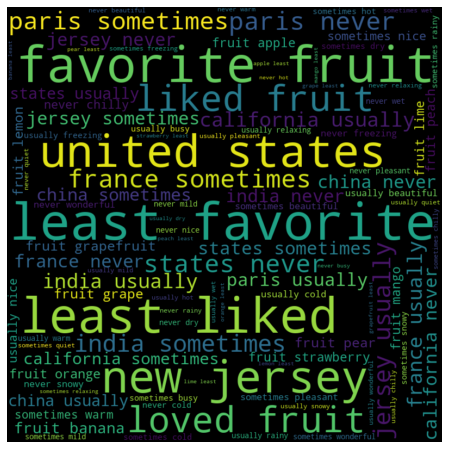

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=800, max_font_size=200, min_font_size=10)

# Generation of the wordcloud from french text
wordcloud.generate_from_text(str(french_text))

# Display thanks to Matplotlib
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# Generation of the wordcloud from english text
wordcloud.generate_from_text(str(english_text))

# Display thanks to Matplotlib
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

#### Tokenizing the data

Since the input data to neural networks needs to be in numerical format, we first turn each sentence into a sequence of word ids using `Tokenizer` function from Keras. Word ids are numerical presentations for words. 

In [ ]:
def tokenize(x: List[str]):
  """Tokenizes sentences into word ids.
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)

  """
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(x)
  t=tokenizer.texts_to_sequences(x)
  return t, tokenizer

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent)) 

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}
Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


#### Padding Sequences

To be able to batch the sequences of word ids together, all sequences need to be of the same length. Therefore, as a second preprocessing step we make sure that all the English sentences have the same length as their respective French translations using `pad_sequence` function form Keras.

In [ ]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    padding=pad_sequences(x,padding='post',maxlen=length)
    return padding

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


#### Preprocessing Pipeline

As mentioned in the introduction section in this excercise your focus is on building different recurrent neural network architectures. Threfore, in the following cell we provide you with a preprocessing pipeline. You can apply this function to the input data to prepare the data for using in neural networks.

In [ ]:
def preprocess(x, y):
    """
     Preprocess input (x) and target (y)
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_text, french_text)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Preprocessed Data Info')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Preprocessed Data Info
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


In [ ]:
def tim_make_input_redable(englischer_input):
 eng_dict = english_tokenizer.index_word
 ausgabe = []
 for i in englischer_input: 
  
   if int(i) == 0: 
    ausgabe.append('PAD')
   else:
    ausgabe.append(eng_dict[int(i)])

 print(' '.join(ausgabe))

### Models

In this section we ask you to build and train Three (optionally four) different neural networks and use them to predict the French Translation of the English sentences.

Make use of the `logits_to_text()` function to transform the logits from output of your networks to a French translation. This helps you to better understand the output of the neural network.

In [ ]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


#### Model 1: Implement a simple RNN network and train the network. 


In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential


In [ ]:
# Model 1: simple RNN model
def rnn_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers and compile the model. (Hint: Use a GRU network followed by a TimeDistributed dense layer from tensorflow.keras.layers module)
    learning_rate=0.001
    
    model = Sequential()
    
    model.add(Input(input_shape[1:]))
    model.add(GRU(units=256, return_sequences=True))
    model.add(TimeDistributed(Dense(french_vocab_size+1)))
    model.add(Activation('softmax'))

    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    # What is the input shape of your model? Which activation function do you choose for the dense layer?
   
    return model




In [ ]:
# TODO: Preprocess and reshape the input to work with a basic RNN. (Hint: Use preproc_english_sentences, preproc_french_sentences and reshape function from keras)
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
print(tmp_x.shape)

(137860, 21, 1)


In [ ]:
# TODO: Train the network you built in rnn_model. What size do you choose for the epochs, batch_size and validation_split?
rnn_model = rnn_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size+1,
    french_vocab_size+1)
rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)

Epoch 1/20
108/108 [==============================] - 33s 21ms/step - loss: 3.2940 - accuracy: 0.4268 - val_loss: 1.8928 - val_accuracy: 0.5616
Epoch 2/20
108/108 [==============================] - 2s 16ms/step - loss: 1.7564 - accuracy: 0.5736 - val_loss: 1.5149 - val_accuracy: 0.5986
Epoch 3/20
108/108 [==============================] - 2s 16ms/step - loss: 1.4717 - accuracy: 0.6096 - val_loss: 1.3600 - val_accuracy: 0.6204
Epoch 4/20
108/108 [==============================] - 2s 16ms/step - loss: 1.3313 - accuracy: 0.6303 - val_loss: 1.2481 - val_accuracy: 0.6469
Epoch 5/20
108/108 [==============================] - 2s 16ms/step - loss: 1.2281 - accuracy: 0.6492 - val_loss: 1.1706 - val_accuracy: 0.6569
Epoch 6/20
108/108 [==============================] - 2s 16ms/step - loss: 1.1556 - accuracy: 0.6604 - val_loss: 1.1198 - val_accuracy: 0.6688
Epoch 7/20
108/108 [==============================] - 2s 16ms/step - loss: 1.1083 - accuracy: 0.6679 - val_loss: 1.0781 - val_accuracy: 0.671

In [ ]:
# TODO: Print prediction(s) for one or more of the English sentences. Hint: Make use of the `logits_to_text` function for transforming output logits to text.
tim_make_input_redable(tmp_x[0])
print(logits_to_text(rnn_model.predict(tmp_x[0].reshape(1,-1,1))[0], french_tokenizer), "\n")

tim_make_input_redable(tmp_x[10])
print(logits_to_text(rnn_model.predict(tmp_x[10].reshape(1,-1,1))[0], french_tokenizer), "\n")

tim_make_input_redable(tmp_x[100])
print(logits_to_text(rnn_model.predict(tmp_x[100].reshape(1,-1,1))[0], french_tokenizer), "\n")

new jersey is sometimes quiet during autumn and it is snowy in april PAD PAD PAD PAD PAD PAD PAD PAD
new jersey est parfois calme en mois de mai et il est chaud en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

the lime is her least liked fruit but the banana is my least liked PAD PAD PAD PAD PAD PAD PAD
les est est son fruit aimé des fruits mais la est est moins moins aimé <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

new jersey is usually quiet during fall but it is usually warm in april PAD PAD PAD PAD PAD PAD PAD
new jersey est généralement calme en printemps mais il est généralement enneigée en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 



#### Model 2: Implement an RNN model using word embeddings

Embeddings are better representation of words. An embedding is a vector representation of a word in n-dimensional space, where n represents the size of the embedding vector.


In [ ]:
# Model 2: Embedding
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers and compile the model. (Hint: Similar to the first model use a GRU network followed by a TimeDistributed dense layer from tensorflow.keras.layers module. 
    # And this time make use of Embedding as well!)
    # What is the input shape of your model? Which activation function do you choose for the dense layer?
    
    learning_rate=0.001
    
    model = Sequential()
    
    model.add(Embedding(french_vocab_size+1, 64, input_length=input_shape[1]))
    model.add(GRU(units=256, return_sequences=True))
    model.add(TimeDistributed(Dense(french_vocab_size+1)))
    model.add(Activation('softmax'))

    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    return model



In [ ]:
# TODO: Preprocess and reshape the input to work with a basic RNN. (Hint: Use preproc_english_sentences, preproc_french_sentences and reshape function from keras)
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))


In [ ]:
# TODO: Train the network you built in rnn_model. What size do you choose for the epochs, batch_size and validation_split?
embed_model = embed_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size+1,
    french_vocab_size+1)

embed_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

Epoch 1/10
108/108 [==============================] - 4s 24ms/step - loss: 4.0176 - accuracy: 0.3906 - val_loss: 2.5486 - val_accuracy: 0.4808
Epoch 2/10
108/108 [==============================] - 2s 20ms/step - loss: 2.3256 - accuracy: 0.5128 - val_loss: 1.6184 - val_accuracy: 0.6120
Epoch 3/10
108/108 [==============================] - 2s 21ms/step - loss: 1.4887 - accuracy: 0.6364 - val_loss: 1.1533 - val_accuracy: 0.7180
Epoch 4/10
108/108 [==============================] - 2s 20ms/step - loss: 1.0671 - accuracy: 0.7386 - val_loss: 0.8349 - val_accuracy: 0.7855
Epoch 5/10
108/108 [==============================] - 2s 21ms/step - loss: 0.7815 - accuracy: 0.7948 - val_loss: 0.6465 - val_accuracy: 0.8196
Epoch 6/10
108/108 [==============================] - 2s 20ms/step - loss: 0.6253 - accuracy: 0.8236 - val_loss: 0.5437 - val_accuracy: 0.8409
Epoch 7/10
108/108 [==============================] - 2s 21ms/step - loss: 0.5242 - accuracy: 0.8470 - val_loss: 0.4674 - val_accuracy: 0.8613

In [ ]:
# TODO: Print prediction(s) for one or more of the English sentences. Hint: Make use of the `logits_to_text` function for transforming output logits to text. 
# (Hint: If you predict on the same sentence you can compare the result of different model on that specific sentence with each other.)
tim_make_input_redable(tmp_x[0])
print(logits_to_text(embed_model.predict(tmp_x[0].reshape(1,-1,1))[0], french_tokenizer), "\n")

tim_make_input_redable(tmp_x[10])
print(logits_to_text(embed_model.predict(tmp_x[10].reshape(1,-1,1))[0], french_tokenizer), "\n")

tim_make_input_redable(tmp_x[100])
print(logits_to_text(embed_model.predict(tmp_x[100].reshape(1,-1,1))[0], french_tokenizer), "\n")

new jersey is sometimes quiet during autumn and it is snowy in april PAD PAD PAD PAD PAD PAD PAD PAD
new jersey est parfois calme en l' de l' il est neigeux avril avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

the lime is her least liked fruit but the banana is my least liked PAD PAD PAD PAD PAD PAD PAD
les chaux est son moins aimé des fruits mais la banane est mon moins aimé <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

new jersey is usually quiet during fall but it is usually warm in april PAD PAD PAD PAD PAD PAD PAD
new jersey est généralement calme en cours automne l' il est il est chaud chaud en <PAD> <PAD> <PAD> <PAD> <PAD> 



#### Model 3: Implement a Bidirectional RNN network.

One of the restrictions of RNN networks is that they only see the data from past. However, Bidirectional RNNs can see the data in both directions past and future. Make use of Bidirectionality and experiment if this feature enhances your network's performance or not.

In [ ]:
# Model 3: Bidirectional RNNs
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO:  Build the layers and compile the model. (Hint: Similar to the first model use a GRU network followed by a TimeDistributed dense layer from tensorflow.keras.layers module. 
    # Don't forget to make your network bidirectional!)
     
    learning_rate=0.001

    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences=True, dropout=0.1),
                        input_shape=input_shape[1:]))
    
    model.add(TimeDistributed(Dense(french_vocab_size+1, activation='softmax') ))
    
 
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    #print(model.summary())
    return model




In [ ]:
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

print(tmp_x.shape)


bd_model = bd_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

bd_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)


(137860, 21, 1)
Epoch 1/20
108/108 [==============================] - 5s 23ms/step - loss: 3.7129 - accuracy: 0.4375 - val_loss: 1.8105 - val_accuracy: 0.5666
Epoch 2/20
108/108 [==============================] - 2s 18ms/step - loss: 1.7754 - accuracy: 0.5666 - val_loss: 1.4923 - val_accuracy: 0.6037
Epoch 3/20
108/108 [==============================] - 2s 18ms/step - loss: 1.5069 - accuracy: 0.6039 - val_loss: 1.3749 - val_accuracy: 0.6202
Epoch 4/20
108/108 [==============================] - 2s 18ms/step - loss: 1.3762 - accuracy: 0.6217 - val_loss: 1.3265 - val_accuracy: 0.6191
Epoch 5/20
108/108 [==============================] - 2s 18ms/step - loss: 1.2944 - accuracy: 0.6372 - val_loss: 1.3079 - val_accuracy: 0.6160
Epoch 6/20
108/108 [==============================] - 2s 18ms/step - loss: 1.2356 - accuracy: 0.6487 - val_loss: 1.3030 - val_accuracy: 0.6142
Epoch 7/20
108/108 [==============================] - 2s 18ms/step - loss: 1.1863 - accuracy: 0.6579 - val_loss: 1.3093 - val_

In [ ]:
# TODO: Print prediction(s) for one or more of the English sentences. Hint: Make use of the `logits_to_text` function for transforming output logits to text.
# (Hint: If you predict on the same sentence you can compare the result of different model on that specific sentence with each other.)
tim_make_input_redable(tmp_x[0])
print(logits_to_text(bd_model.predict(tmp_x[0].reshape(1,-1,1))[0], french_tokenizer), "\n")

tim_make_input_redable(tmp_x[10])
print(logits_to_text(bd_model.predict(tmp_x[10].reshape(1,-1,1))[0], french_tokenizer), "\n")

tim_make_input_redable(tmp_x[100])
print(logits_to_text(bd_model.predict(tmp_x[100].reshape(1,-1,1))[0], french_tokenizer), "\n")

new jersey is sometimes quiet during autumn and it is snowy in april PAD PAD PAD PAD PAD PAD PAD PAD
new unis est parfois froid en janvier mais il est agréable en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

the lime is her least liked fruit but the banana is my least liked PAD PAD PAD PAD PAD PAD PAD
le raisin est votre fruit moins moins mais le raisin est votre moins moins <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

new jersey is usually quiet during fall but it is usually warm in april PAD PAD PAD PAD PAD PAD PAD
new unis est parfois froid à juin mais il est parfois agréable en mai <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 



#### Model 4: Implement an Encoder-Decoder model (Optional)

In [ ]:

def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # OPTIONAL: Implement

    learning_rate=0.001

    model = Sequential()
    #encoder
    model.add(GRU(128, input_shape=input_shape[1:], return_sequences=False) )
    model.add(RepeatVector(output_sequence_length))
    #decoder
    model.add(GRU(128, return_sequences=True) )
    #output
    model.add(TimeDistributed(Dense(french_vocab_size+1, activation='softmax') ))
    
   
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model




In [ ]:
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))


In [ ]:
encdec_model = encdec_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

In [ ]:
encdec_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)


Epoch 1/20
108/108 [==============================] - 5s 23ms/step - loss: 3.8893 - accuracy: 0.4020 - val_loss: 2.5087 - val_accuracy: 0.4779
Epoch 2/20
108/108 [==============================] - 2s 18ms/step - loss: 2.4549 - accuracy: 0.4820 - val_loss: 2.2640 - val_accuracy: 0.4977
Epoch 3/20
108/108 [==============================] - 2s 18ms/step - loss: 2.2192 - accuracy: 0.5022 - val_loss: 2.0937 - val_accuracy: 0.5139
Epoch 4/20
108/108 [==============================] - 2s 18ms/step - loss: 2.0176 - accuracy: 0.5271 - val_loss: 1.8068 - val_accuracy: 0.5484
Epoch 5/20
108/108 [==============================] - 2s 18ms/step - loss: 1.7718 - accuracy: 0.5524 - val_loss: 1.6698 - val_accuracy: 0.5689
Epoch 6/20
108/108 [==============================] - 2s 18ms/step - loss: 1.6441 - accuracy: 0.5734 - val_loss: 1.5723 - val_accuracy: 0.5883
Epoch 7/20
108/108 [==============================] - 2s 18ms/step - loss: 1.5517 - accuracy: 0.5890 - val_loss: 1.4927 - val_accuracy: 0.5993

In [ ]:
tim_make_input_redable(tmp_x[0])
print(logits_to_text(encdec_model.predict(tmp_x[0].reshape(1,-1,1))[0], french_tokenizer), "\n")

tim_make_input_redable(tmp_x[10])
print(logits_to_text(encdec_model.predict(tmp_x[10].reshape(1,-1,1))[0], french_tokenizer), "\n")

tim_make_input_redable(tmp_x[100])
print(logits_to_text(encdec_model.predict(tmp_x[100].reshape(1,-1,1))[0], french_tokenizer), "\n")


new jersey is sometimes quiet during autumn and it is snowy in april PAD PAD PAD PAD PAD PAD PAD PAD
new jersey est parfois agréable en l' et il est est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

the lime is her least liked fruit but the banana is my least liked PAD PAD PAD PAD PAD PAD PAD
la citron est son fruit aimé aimé mais la la est est moins moins <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

new jersey is usually quiet during fall but it is usually warm in april PAD PAD PAD PAD PAD PAD PAD
new jersey est parfois chaud en l' et il est jamais est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 



#### Finally, you can use all the models you built in this exercise to create a model that incorporates embedding and bidirectionality into one model. (Optional)

In [ ]:

def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    learning_rate=0.001

    model = Sequential()
    model.add(Embedding(french_vocab_size+1 ,128 , input_length=input_shape[1]))
    #encoder
    model.add(Bidirectional(GRU(128, return_sequences=False)) )
    model.add(RepeatVector(output_sequence_length))
    #decoder
    model.add(Bidirectional(GRU(128, return_sequences=True)) )
    #output
    model.add(TimeDistributed(Dense(french_vocab_size+1, activation='softmax') ))
    
    
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    return model


In [ ]:
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))


In [ ]:
model_final = model_final(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

model_final.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)


Epoch 1/20
108/108 [==============================] - 10s 48ms/step - loss: 3.7025 - accuracy: 0.4044 - val_loss: 2.1117 - val_accuracy: 0.4906
Epoch 2/20
108/108 [==============================] - 4s 39ms/step - loss: 1.9664 - accuracy: 0.5208 - val_loss: 1.6915 - val_accuracy: 0.5648
Epoch 3/20
108/108 [==============================] - 4s 39ms/step - loss: 1.5762 - accuracy: 0.5929 - val_loss: 1.3741 - val_accuracy: 0.6369
Epoch 4/20
108/108 [==============================] - 4s 39ms/step - loss: 1.3057 - accuracy: 0.6506 - val_loss: 1.1762 - val_accuracy: 0.6810
Epoch 5/20
108/108 [==============================] - 4s 39ms/step - loss: 1.1285 - accuracy: 0.6913 - val_loss: 1.0396 - val_accuracy: 0.7119
Epoch 6/20
108/108 [==============================] - 4s 39ms/step - loss: 1.0243 - accuracy: 0.7144 - val_loss: 0.9761 - val_accuracy: 0.7248
Epoch 7/20
108/108 [==============================] - 4s 39ms/step - loss: 0.9506 - accuracy: 0.7305 - val_loss: 0.9015 - val_accuracy: 0.741

In [ ]:
tim_make_input_redable(tmp_x[0])
print(logits_to_text(model_final.predict(tmp_x[0].reshape(1,-1,1))[0], french_tokenizer), "\n")

tim_make_input_redable(tmp_x[10])
print(logits_to_text(model_final.predict(tmp_x[10].reshape(1,-1,1))[0], french_tokenizer), "\n")

tim_make_input_redable(tmp_x[100])
print(logits_to_text(model_final.predict(tmp_x[100].reshape(1,-1,1))[0], french_tokenizer), "\n")

new jersey is sometimes quiet during autumn and it is snowy in april PAD PAD PAD PAD PAD PAD PAD PAD
new jersey est parfois calme pendant l' et et est est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

the lime is her least liked fruit but the banana is my least liked PAD PAD PAD PAD PAD PAD PAD
la chaux est son moins aimé des fruits mais la banane est mon moins aimé <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

new jersey is usually quiet during fall but it is usually warm in april PAD PAD PAD PAD PAD PAD PAD
new jersey est généralement calme au l'automne mais il est généralement il en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 



### Final Notes and TODOs




*   In this exercise we focus on  learning different recurrent network architectures for machine translation, However we don't evaluate the models on a separate test set. To follow best machine learning practices, you can make use of the `sklearn.model_selecttion.train_test_split()` function to create separate training and test datasets. You can then retrain each of the models on the training set and evaluate the prediction accuracy using the hold out set. Observe how the best model performance might change.
* If you don't have any idea about French (like me :D) you can use a translater like [google translat](https://translate.google.com/) to compare the prediction(s) from your models with the respective original English sentence(s).
*   TODO: Finally, you can also try to train and predict your models on other language pairs. As a convenient example, you can use your models to translate from French to English since you already have the data available.





# Use Model as translater


In [ ]:
test_sentence = 'i like apples' # natürlich müssen alle Wörter dem Modell bekannt sein
test_sentence = [english_tokenizer.word_index[word] for word in test_sentence.split()] #umwandeln des textes in zahlen werten
test_sentence = pad_sequences([test_sentence], maxlen=21, padding='post') # hinzufügen der pads


In [ ]:
tim_make_input_redable(test_sentence[0])
print(logits_to_text(model_final.predict(test_sentence.reshape(1,-1,1).reshape(1,-1,1))[0], french_tokenizer), "\n")

i like bananas PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
j'aime pommes et <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 



# Use train, test, split

In [ ]:
# use train test split to get test set 
from sklearn.model_selection import train_test_split
Train_english, Test_english = train_test_split(english_text, random_state=42, test_size = 42)
Train_french, Test_french = train_test_split(french_text, random_state=42, test_size = 42)


In [ ]:
# preprocess training data
train_preproc_english_sentences, train_preproc_french_sentences, train_english_tokenizer, train_french_tokenizer =\
    preprocess(Train_english, Train_french)
    
train_max_english_sequence_length = train_preproc_english_sentences.shape[1]
train_max_french_sequence_length = train_preproc_french_sentences.shape[1]
train_english_vocab_size = len(train_english_tokenizer.word_index)
train_french_vocab_size = len(train_french_tokenizer.word_index)

In [ ]:
# preprocess test data
test_preproc_french_sentences = train_french_tokenizer.texts_to_sequences(Test_french)
test_preproc_french_sentences = pad_sequences(test_preproc_french_sentences, padding="post", maxlen=21)

test_preproc_english_sentences = train_english_tokenizer.texts_to_sequences(Test_english)
test_preproc_english_sentences = pad_sequences(test_preproc_english_sentences, padding="post", maxlen=21)

In [ ]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    learning_rate=0.001

    model = Sequential()
    model.add(Embedding(french_vocab_size+1 ,128 , input_length=input_shape[1]))
    #encoder
    model.add(Bidirectional(GRU(128, return_sequences=False)) )
    model.add(RepeatVector(output_sequence_length))
    #decoder
    model.add(Bidirectional(GRU(128, return_sequences=True)) )
    #output
    model.add(TimeDistributed(Dense(french_vocab_size+1, activation='softmax') ))
    
    
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    return model


In [ ]:
model_final = model_final(
    tmp_x.shape,
    train_preproc_french_sentences.shape[1],
    len(train_english_tokenizer.word_index)+1,
    len(train_french_tokenizer.word_index)+1)

model_final.fit(tmp_x, train_preproc_french_sentences, batch_size=1024, epochs=20, validation_split=0.2)


Epoch 1/20
108/108 [==============================] - 9s 47ms/step - loss: 3.7169 - accuracy: 0.4015 - val_loss: 2.1477 - val_accuracy: 0.4801
Epoch 2/20
108/108 [==============================] - 4s 38ms/step - loss: 1.9808 - accuracy: 0.5221 - val_loss: 1.6106 - val_accuracy: 0.5841
Epoch 3/20
108/108 [==============================] - 4s 38ms/step - loss: 1.5299 - accuracy: 0.6054 - val_loss: 1.3448 - val_accuracy: 0.6408
Epoch 4/20
108/108 [==============================] - 4s 39ms/step - loss: 1.2990 - accuracy: 0.6498 - val_loss: 1.1953 - val_accuracy: 0.6726
Epoch 5/20
108/108 [==============================] - 4s 38ms/step - loss: 1.1654 - accuracy: 0.6798 - val_loss: 1.0842 - val_accuracy: 0.7014
Epoch 6/20
108/108 [==============================] - 4s 39ms/step - loss: 1.0537 - accuracy: 0.7103 - val_loss: 0.9721 - val_accuracy: 0.7328
Epoch 7/20
108/108 [==============================] - 4s 39ms/step - loss: 0.9470 - accuracy: 0.7374 - val_loss: 0.9028 - val_accuracy: 0.7462

In [ ]:
# Look at accuracy on test set

model_final.evaluate(test_preproc_english_sentences.reshape(-1,21,1), test_preproc_french_sentences)

#Accuracy looks good. Maybe to good? 

2/2 [==============================] - 0s 10ms/step - loss: 0.3725 - accuracy: 0.8980


[0.3725161850452423, 0.8979591727256775]

In [ ]:
tmp_x = pad(test_preproc_english_sentences, test_preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

(42, 21, 1)

In [ ]:
def tim_make_input_redable(englischer_input):
 eng_dict = train_english_tokenizer.index_word
 ausgabe = []
 for i in englischer_input: 
  
   if int(i) == 0: 
    ausgabe.append('PAD')
   else:
    ausgabe.append(eng_dict[int(i)])

 print(' '.join(ausgabe))

In [ ]:
tim_make_input_redable(tmp_x[0])
print(logits_to_text(model_final.predict(tmp_x[0].reshape(1,-1,1))[0], french_tokenizer), "\n")

tim_make_input_redable(tmp_x[10])
print(logits_to_text(model_final.predict(tmp_x[10].reshape(1,-1,1))[0], french_tokenizer), "\n")

tim_make_input_redable(tmp_x[20])
print(logits_to_text(model_final.predict(tmp_x[20].reshape(1,-1,1))[0], french_tokenizer), "\n")

china is usually busy during september but it is sometimes cold in spring PAD PAD PAD PAD PAD PAD PAD PAD
chine est généralement occupé en septembre mais il est parfois occupé au printemps <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

china is beautiful during february and it is wet in fall PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
chine est belle en février et il est humide à l' automne <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

france is wonderful during november and it is snowy in fall PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
la est merveilleux au mois de novembre et il est froid à l' automne <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 



Those examples look quite good to me